In [121]:
import matplotlib.pyplot as plt
import numpy as np
import os

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.fhn import FHNModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.optimal_control import oc_fhn
from neurolib.optimal_control import cost_functions as cost_functions

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

# We define colors for later convenience
color_x = 'red'
color_y = 'blue'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [122]:
# define plot function for later convenience
def plot_singlenode(model, duration, dt, state, target, control, input, weight_array=[], M=1):
    fig, ax = plt.subplots( 3,1, figsize=(8,6), constrained_layout=True)

    # Plot the target (dashed line) and unperturbed activity
    t_array = np.arange(0, duration+dt, dt)

    ax[0].plot(t_array, state[0,0,:], label="x", color=color_x, linewidth=1)
    ax[0].plot(t_array, state[0,1,:], label="y", color=color_y, linewidth=1)
    ax[0].plot(t_array, target[0,0,:], linestyle='dashed', label="Target x", color=color_x)
    ax[0].plot(t_array, target[0,1,:], linestyle='dashed', label="Target y", color=color_y)
    ax[0].legend()
    ax[0].set_title("Activity without stimulation and target activity")

    for m in range(M-1):
        model.run()
        state = np.concatenate((np.concatenate( (model.params["xs_init"], model.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (model.x, model.y), axis=1)), axis=2)
        ax[0].plot(t_array, state[0,0,:], label="x", color=color_x, linewidth=1)
        ax[0].plot(t_array, state[0,1,:], label="y", color=color_y, linewidth=1)

    # Plot the target control signal (dashed line) and "initial" zero control signal
    ax[1].plot(t_array, control[0,0,:], label="stimulation x", color=color_x)
    ax[1].plot(t_array, control[0,1,:], label="stimulation y", color=color_y)
    ax[1].plot(t_array, input[0,0,:], linestyle='dashed', label="input x", color=color_x)
    ax[1].plot(t_array, input[0,1,:], linestyle='dashed', label="input y", color=color_y)
    ax[1].legend()
    ax[1].set_title("Active stimulation and input stimulation")

    ax[2].plot(weight_array)
    ax[2].set_title("Cost throughout optimization.")

    plt.show()

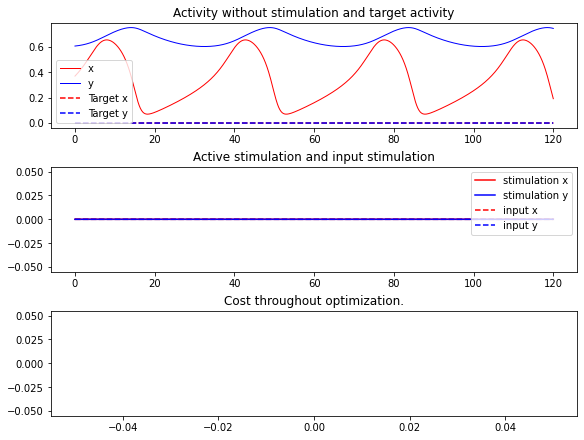

In [123]:
fhn = FHNModel()
fhn.params.sigma_ou = 0.
fhn.params.x_ou_mean = 0.

dt = fhn.params["dt"]
duration = 120.
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
zero_control =np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]

fhn.params["duration"] = duration
x_init = 0.
y_init = 0.
fhn.params["xs_init"] = np.array([[x_init]])
fhn.params["ys_init"] = np.array([[y_init]])
fhn.params["x_ext"] = zero_input
fhn.params["y_ext"] = zero_input
fhn.run()

target = np.concatenate((np.concatenate( (fhn.params["xs_init"], fhn.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (fhn.x, fhn.y), axis=1)), axis=2)

fhn.params.x_ou_mean = 0.8
fhn.run()
x_init_osc = np.array([[fhn.x[0,-1]]])
y_init_osc = np.array([[fhn.y[0,-1]]])
fhn.params["xs_init"] = x_init_osc
fhn.params["ys_init"] = y_init_osc
fhn.run()

state = np.concatenate((np.concatenate( (fhn.params["xs_init"], fhn.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (fhn.x, fhn.y), axis=1)), axis=2)

plot_singlenode(fhn, duration, dt, state, target, zero_control, zero_control)

ERROR:root:nan in model output!
ERROR:root:nan in model output!
ERROR:root:nan in model output!
ERROR:root:nan in model output!
ERROR:root:nan in model output!
ERROR:root:nan in model output!
ERROR:root:nan in model output!
ERROR:root:nan in model output!


Compute control for a deterministic system
Cost in iteration 1: 69.56488390214693
diverging model output, decrease step size to  5.0
diverging model output, decrease step size to  2.5
diverging model output, decrease step size to  1.25
diverging model output, decrease step size to  0.625
diverging model output, decrease step size to  0.3125
diverging model output, decrease step size to  0.15625
diverging model output, decrease step size to  0.078125
diverging model output, decrease step size to  0.0390625
Cost in iteration 2: 54.007036265925215
Cost in iteration 3: 44.89302264190102
Cost in iteration 4: 44.609796473654555
Cost in iteration 5: 43.680447470646186
Cost in iteration 6: 43.57698938039339
Cost in iteration 7: 43.380877741421656
Cost in iteration 8: 43.14898905811209
Cost in iteration 9: 43.10237435281518
Cost in iteration 10: 42.605243260619
Cost in iteration 11: 42.492457807620816
Cost in iteration 12: 42.28152658266966
Cost in iteration 13: 42.13797197405564
Cost in iterat

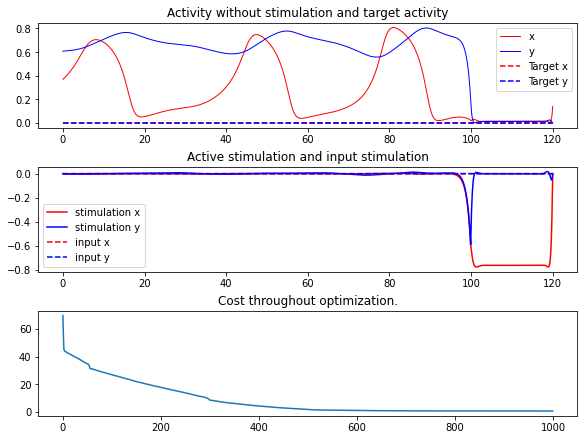

In [124]:
fhn.params["x_ext"] = zero_input
fhn.params["y_ext"] = zero_input
w2 = 1e-2
printarray = np.concatenate( (np.arange(0,101,1), np.arange(200,1001,100)) )
fhn_controlled_noisefree = oc_fhn.OcFhn(fhn, target, w_p=1, w_2=w2, print_array=printarray, precision_cost_interval=[1000,None])

# We run 100 iterations of the optimal control gradient descent algorithm
fhn_controlled_noisefree.optimize(1000)

state = fhn_controlled_noisefree.get_xs()
control_noisefree = fhn_controlled_noisefree.control

plot_singlenode(fhn_controlled_noisefree.model, duration, dt, state, target, control_noisefree, zero_control, fhn_controlled_noisefree.cost_history)


In [ ]:
fhn_controlled_noisefree.optimize(1000)

state = fhn_controlled_noisefree.get_xs()
control_noisefree = fhn_controlled_noisefree.control

plot_singlenode(fhn_controlled_noisefree.model, duration, dt, state, target, control_noisefree, zero_control, fhn_controlled_noisefree.cost_history)

In [156]:
sigma_array = [2. * 1e-3, 6. * 1e-3, 2.* 1e-2]
M_array = [3,10,20]

weights = np.zeros(( len(sigma_array) ))
controls = [ [None, None, None], [None, None, None], [None, None, None] ]
costs = [ [None, None, None, None], [None, None, None, None], [None, None, None, None] ]

In [157]:
fhn_noise = FHNModel()
fhn_noise.params.sigma_ou = 0.
fhn_noise.params.x_ou_mean = 0.

In [158]:
fhn_noise.params.duration = 1. * 1e7
fhn_noise.params["xs_init"] = np.array([[x_init]])
fhn_noise.params["ys_init"] = np.array([[y_init]])
fhn_noise.params["x_ext"] = zero_input
fhn_noise.params["y_ext"] = zero_input

for i_s in range(len(sigma_array)):
    fhn_noise.params.sigma_ou = sigma_array[i_s]

    fhn_noise.run()
    weights[i_s] = 1. / (np.std(fhn_noise.x[0,100:]) + np.std(fhn_noise.y[0,100:]) )

print(weights)

# [45.99594752  9.07230569]

[22.93588091  7.41863969  1.94642078]


ERROR:root:nan in model output!
ERROR:root:nan in model output!
ERROR:root:nan in model output!
ERROR:root:nan in model output!
ERROR:root:nan in model output!
ERROR:root:nan in model output!
ERROR:root:nan in model output!
ERROR:root:nan in model output!
ERROR:root:nan in model output!


--------------------------------------------------------------
---------------------------- sigma, M =  0.006 20
Compute control for a noisy system
diverging model output, decrease step size to  5.0
diverging model output, decrease step size to  2.5
diverging model output, decrease step size to  1.25
diverging model output, decrease step size to  0.625
diverging model output, decrease step size to  0.3125
diverging model output, decrease step size to  0.15625
diverging model output, decrease step size to  0.078125
diverging model output, decrease step size to  0.0390625
diverging model output, decrease step size to  0.01953125
Mean cost in iteration 10: 361.7358325749733
try another time
Mean cost in iteration 20: 354.7118307479554


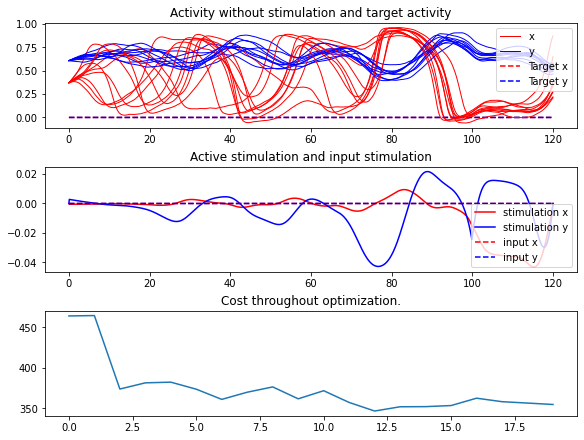

ERROR:root:nan in model output!
ERROR:root:nan in model output!
ERROR:root:nan in model output!
ERROR:root:nan in model output!
ERROR:root:nan in model output!
ERROR:root:nan in model output!
ERROR:root:nan in model output!


--------------------------------------------------------------
---------------------------- sigma, M =  0.02 3
Compute control for a noisy system
diverging model output, decrease step size to  5.0
diverging model output, decrease step size to  2.5
diverging model output, decrease step size to  1.25
diverging model output, decrease step size to  0.625
diverging model output, decrease step size to  0.3125
diverging model output, decrease step size to  0.15625
diverging model output, decrease step size to  0.078125


ERROR:root:nan in model output!


diverging model output, decrease step size to  0.0390625
Mean cost in iteration 10: 161.7308106425344
Mean cost in iteration 20: 179.77869691654593


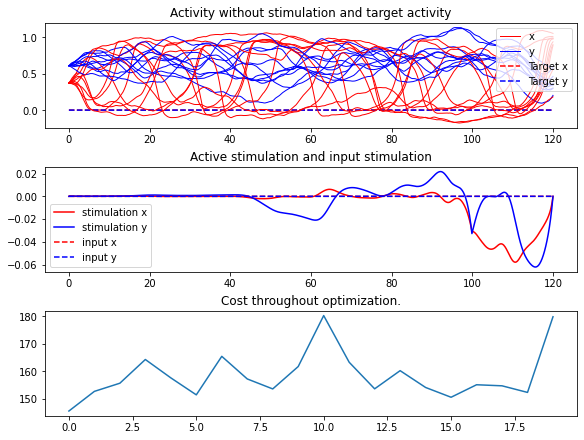

ERROR:root:nan in model output!
ERROR:root:nan in model output!
ERROR:root:nan in model output!
ERROR:root:nan in model output!
ERROR:root:nan in model output!
ERROR:root:nan in model output!
ERROR:root:nan in model output!
ERROR:root:nan in model output!


--------------------------------------------------------------
---------------------------- sigma, M =  0.02 10
Compute control for a noisy system
diverging model output, decrease step size to  5.0
diverging model output, decrease step size to  2.5
diverging model output, decrease step size to  1.25
diverging model output, decrease step size to  0.625
diverging model output, decrease step size to  0.3125
diverging model output, decrease step size to  0.15625
diverging model output, decrease step size to  0.078125
diverging model output, decrease step size to  0.0390625
Mean cost in iteration 10: 146.1806019407032
try another time
Mean cost in iteration 20: 144.73573898953003


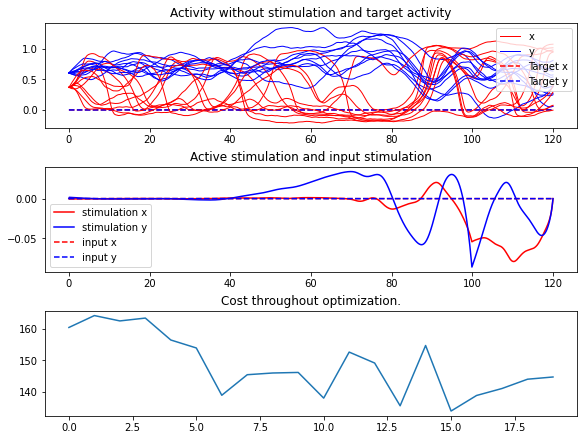

ERROR:root:nan in model output!
ERROR:root:nan in model output!
ERROR:root:nan in model output!
ERROR:root:nan in model output!
ERROR:root:nan in model output!
ERROR:root:nan in model output!


--------------------------------------------------------------
---------------------------- sigma, M =  0.02 20
Compute control for a noisy system
diverging model output, decrease step size to  5.0
diverging model output, decrease step size to  2.5
diverging model output, decrease step size to  1.25
diverging model output, decrease step size to  0.625
diverging model output, decrease step size to  0.3125
diverging model output, decrease step size to  0.15625


ERROR:root:nan in model output!


diverging model output, decrease step size to  0.078125
Mean cost in iteration 10: 138.03360078976252
Mean cost in iteration 20: 176.3823200490499


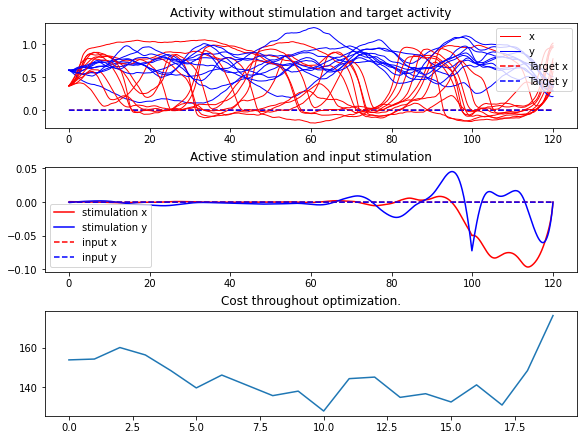

In [164]:
fhn_noise.params.duration = duration
fhn_noise.params["xs_init"] = x_init_osc
fhn_noise.params["ys_init"] = y_init_osc

fhn_noise.params.x_ou_mean = 0.8
M_val = 40
fhn_noise.run()
printarray = np.concatenate( (np.arange(0,101,10), np.arange(200,1001,100)) )

for i_s in range(len(sigma_array)):
    for i_m in range(len(M_array)):

        if i_m in []:
            continue

        if i_s in []:
            continue

        if type(costs[i_s][i_m+1]) != type(None):
            continue

        print("--------------------------------------------------------------")
        print("---------------------------- sigma, M = ", sigma_array[i_s], M_array[i_m])

        fhn_noise.params["x_ext"] = zero_input
        fhn_noise.params["y_ext"] = zero_input
        fhn_noise.params.sigma_ou = sigma_array[i_s]

        fhn_controlled_models = oc_fhn.OcFhn(fhn_noise, target, w_p=weights[i_s], w_2=w2, print_array=printarray, precision_cost_interval=[1000,None],
                                    M=int(M_array[i_m]),
                                    #M = 10,
                                    M_validation=M_val, validate_per_step=True, method='3')

        # We run 100 iterations of the optimal control gradient descent algorithm
        fhn_controlled_models.optimize(20)

        state = fhn_controlled_models.get_xs()
        controls[i_s][i_m] = fhn_controlled_models.control
        costs[i_s][i_m+1] = fhn_controlled_models.cost_history

        plot_singlenode(fhn_controlled_models.model, duration, dt, state, target, controls[i_s][i_m], zero_control, fhn_controlled_models.cost_history, M=10)



In [165]:
fhn_plot = FHNModel()
fhn_plot.params.x_ou_mean = 0.8

fhn_plot.params["duration"] = duration
fhn_plot.params["xs_init"] = x_init_osc
fhn_plot.params["ys_init"] = y_init_osc


In [166]:
for i_s in range(len(sigma_array)):

    print(i_s)

    fhn_plot.params.sigma_ou = sigma_array[i_s]

    fhn_plot.params["x_ext"] = control_noisefree[:,0,:]
    fhn_plot.params["y_ext"] = control_noisefree[:,1,:]

    cost_validation = 0.0
    energy_cost = cost_functions.energy_cost(control_noisefree, w_2=w2)

    for m in range(M_val):
        fhn_plot.run()
        state = np.concatenate((np.concatenate( (fhn_plot.params["xs_init"], fhn_plot.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (fhn_plot.x, fhn_plot.y), axis=1)), axis=2)
        precision_cost = cost_functions.precision_cost(target, state, weights[i_s], 1, np.ones( (1, 2)), [1000,-1])
        cost_validation += precision_cost + energy_cost

    costs[i_s][0] = cost_validation/M_val

print(costs[0][0], costs[1][0], costs[2][0])

0
1
2
4.019803648752339 8.937498259276046 30.85797916896525


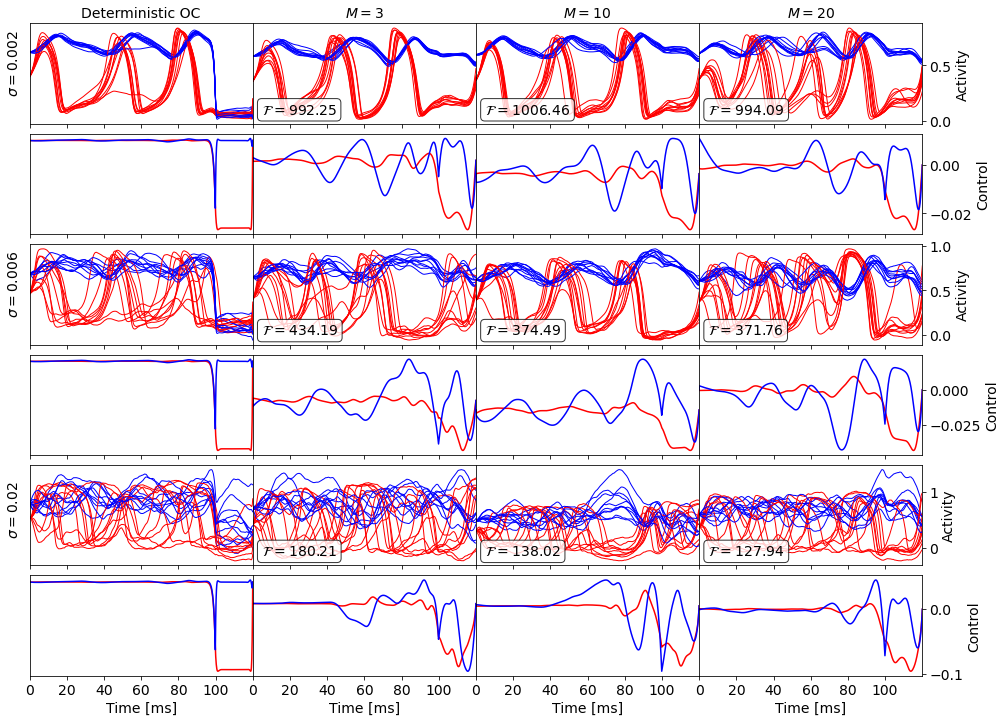

In [170]:
row, col = 6, 4

fig = plt.figure(figsize=(16,12))
gs = fig.add_gridspec(row, col, hspace=0.1, wspace=0)
ax = gs.subplots(sharex='col')
box_props = dict(boxstyle='round', facecolor='white', alpha=0.8)
fs = 14
savepath = '..' + os.sep + '..' + os.sep + '..' + os.sep + 'Talks_Conf_Workshops_Schools' + os.sep + '22' + os.sep + '2022_Wittenberg' + os.sep + 'talk' + os.sep + 'talk' + os.sep + 'images'

time_array = np.arange(0, duration+dt, dt)

for i_s in range(len(sigma_array)):
    ax[2*i_s, 0].text(-0.1, 0.3, r'$\sigma = $'+ "{}".format(sigma_array[i_s]),
    transform=ax[2*i_s, 0].transAxes, rotation='vertical', fontsize=fs)

    ax[2*i_s + 1, 0].plot(time_array, control_noisefree[0,0,:], color=color_x)
    ax[2*i_s + 1, 0].plot(time_array, control_noisefree[0,1,:], color=color_y)
    
    fhn_plot.params.sigma_ou = sigma_array[i_s]

    fhn_plot.params["x_ext"] = control_noisefree[:,0,:]
    fhn_plot.params["y_ext"] = control_noisefree[:,1,:]

    for m in range(10):
        fhn_plot.run()
        ax[2*i_s, 0].plot(time_array[1:], fhn_plot.x[0,:], color=color_x, linewidth=1)
        ax[2*i_s, 0].plot(time_array[1:], fhn_plot.y[0,:], color=color_y, linewidth=1)

    ax[2*i_s, 0].text(0.04,0.1, r'$\mathcal{F} = $' + "{:.2f}".format(costs[i_s][0]),
        transform=ax[2*i_s, i_m+1].transAxes, fontsize=fs, bbox=box_props)

    for i_m in range(len(M_array)):
        ax[2*i_s + 1, i_m+1].plot(time_array, controls[i_s][i_m][0,0,:], color=color_x)
        ax[2*i_s + 1, i_m+1].plot(time_array, controls[i_s][i_m][0,1,:], color=color_y)

        ax[2*i_s, i_m+1].text(0.04,0.1, r'$\mathcal{F} = $' + "{:.2f}".format(np.mean(costs[i_s][i_m+1][-10])),
        transform=ax[2*i_s, i_m+1].transAxes, fontsize=fs, bbox=box_props)

        fhn_plot.params["x_ext"] = controls[i_s][i_m][:,0,:]
        fhn_plot.params["y_ext"] = controls[i_s][i_m][:,1,:]

        for m in range(10):
            fhn_plot.run()
            ax[2*i_s, i_m+1].plot(time_array[1:], fhn_plot.x[0,:], color=color_x, linewidth=1)
            ax[2*i_s, i_m+1].plot(time_array[1:], fhn_plot.y[0,:], color=color_y, linewidth=1)



    for k in range(col-1):
        ax[2*i_s,k].set_yticks([])
        ax[2*i_s+1,k].set_yticks([])
    
    ax[2*i_s,-1].yaxis.tick_right()
    ax[2*i_s+1,-1].yaxis.tick_right()

    ax[2*i_s,-1].set_ylabel("Activity", fontsize=fs)
    ax[2*i_s,-1].yaxis.set_label_position("right")
    ax[2*i_s+1,-1].set_ylabel("Control", fontsize=fs)
    ax[2*i_s+1,-1].yaxis.set_label_position("right")


for k in range(col):
    for j in range(row-1):
        ax[j,k].set_xticks([])
        ax[j,k].set_xlim([0,duration])
        ax[j,k].tick_params(axis='both', labelsize=fs)
    ax[-1,k].set_xticks(np.arange(0,120,20))
    ax[-1,k].set_xlim([0,duration])
    ax[-1,k].tick_params(axis='both', labelsize=fs)
    ax[-1,k].set_xlabel("Time [ms]", fontsize=fs)

for i_m in range(len(M_array)):
    ax[0,i_m+1].set_title(r"$M=$" + "{}".format(M_array[i_m]), fontsize=fs)

ax[0,0].set_title(r"Deterministic OC", fontsize=fs)

fig.savefig(os.path.join(savepath, 'FHN_osc_down_traces.jpg'))
plt.show()


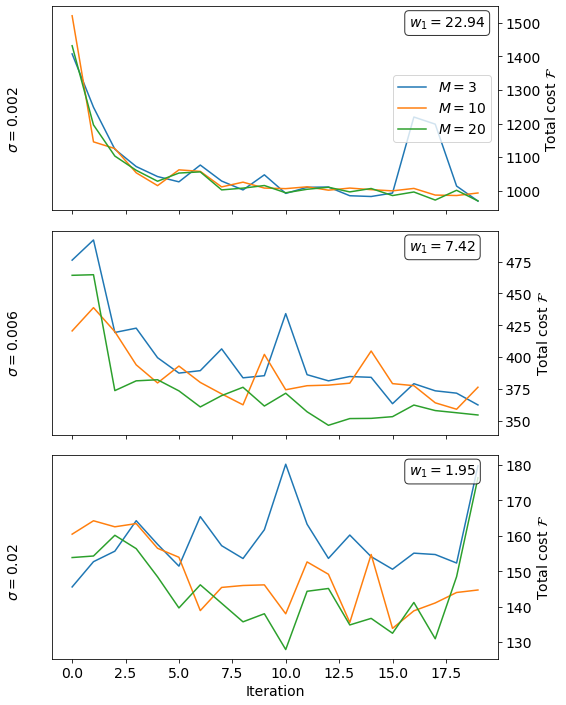

In [168]:
row, col = 3, 1

fig = plt.figure(figsize=(8,12))
gs = fig.add_gridspec(row, col, hspace=0.1, wspace=0)
ax = gs.subplots(sharex='col')

for i_s in range(len(sigma_array)):
    for i_m in range(len(M_array)):
        ax[i_s].plot(costs[i_s][i_m+1], label=r'$M=$' + '{}'.format(M_array[i_m]))

    ax[i_s].text(0.8,0.9, r'$w_1 = $' + "{:.2f}".format(weights[i_s]),
    transform=ax[i_s].transAxes, fontsize=fs, bbox=box_props)

    ax[i_s].text(-0.1, 0.3, r'$\sigma = $'+ "{}".format(sigma_array[i_s]), transform=ax[i_s].transAxes, rotation='vertical', fontsize=fs)

    ax[i_s].set_ylabel(r'Total cost $\mathcal{F}$', fontsize=fs)
    ax[i_s].yaxis.set_label_position("right")
    ax[i_s].yaxis.tick_right()
    ax[i_s].tick_params(axis='both', labelsize=fs)

ax[0].legend(loc='center right', fontsize=fs)
ax[-1].set_xlabel("Iteration", fontsize=fs)

fig.savefig(os.path.join(savepath, 'FHN_osc_down_cost.jpg'))
plt.show()